<a href="https://colab.research.google.com/github/Balaji-0-5/N-Body-Simulation/blob/main/Brute_force.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import numba as nb
import json
from google.colab import files
print("numpy :",np.__version__)
print("numba :",nb.__version__)
print("json :",json.__version__) 

numpy : 1.22.4
numba : 0.56.4
json : 2.0.9


The seed is an integer value that is used to initialize the random number generator. 
By setting the seed to a specific value, the random number generator will always produce 
the same sequence of numbers. This is useful for reproducibility of results.

In [ ]:
np.random.seed(123)# Set the seed for the random number generator

Defining the parameters of the simulation

In [ ]:
# Define constants (in units of kpc, Msun, and Myr)
G = 4.498768e-6 # kpc^3 / (Msun Myr^2)
R0 = 8.0 # kpc (distance from Sun to Galactic center)
M_bulge = 5e2 # Msun
M_disk = 3e3 # Msun
M_halo = 2e4 # Msun
R_bulge = 0.2 # kpc (scale radius of bulge)
R_disk = 0.7 # kpc (scale length of disk)
R_halo = 3.0 # kpc (scale radius of halo)
z0_disk = 0.05 # kpc (scale height of disk)
z0_bulge = 0.02 # kpc (scale height of bulge)

# Generate particle positions
N_bulge = 1000
N_disk = 10000
N_halo = 9000
N_tot = N_bulge + N_disk + N_halo

# Generate positions and momenta for the bulge particles
X_bulge = np.random.normal(scale=R_bulge, size=N_bulge)
Y_bulge = np.random.normal(scale=R_bulge, size=N_bulge)
Z_bulge = np.random.normal(scale=z0_bulge, size=N_bulge)
R_bulge = np.sqrt(X_bulge**2 + Y_bulge**2 + Z_bulge**2)
M_bulge_particle = M_bulge/N_bulge
P_bulge = np.sqrt(2*M_bulge_particle*G*R_bulge**2/R_bulge)*(np.random.normal(size=N_bulge))
Px_bulge = -P_bulge*X_bulge/R_bulge
Py_bulge = -P_bulge*Y_bulge/R_bulge
Pz_bulge = -P_bulge*Z_bulge/R_bulge

# Generate positions and momenta for the disk particles
R_disk = np.random.exponential(scale=R_disk, size=N_disk)
phi_disk = np.random.uniform(0, 2*np.pi, size=N_disk)
X_disk = R_disk*np.cos(phi_disk)
Y_disk = R_disk*np.sin(phi_disk)
Z_disk = np.random.normal(scale=z0_disk, size=N_disk)
M_disk_particle = M_disk/N_disk
P_disk = np.sqrt(2*M_disk_particle*G*R_disk)*np.sqrt(R0/R_disk)*(1 + np.random.normal(scale=0.1, size=N_disk))
Px_disk = -P_disk*np.sin(phi_disk)
Py_disk = P_disk*np.cos(phi_disk)
Pz_disk = np.zeros(N_disk)

# Generate positions and momenta for the halo particles
R_halo = np.random.exponential(scale=R_halo, size=N_halo)
phi_halo = np.random.uniform(0, 2*np.pi, size=N_halo)
theta_halo = np.arccos(2*np.random.uniform(size=N_halo) - 1)
X_halo = R_halo*np.sin(theta_halo)*np.cos(phi_halo)
Y_halo = R_halo*np.sin(theta_halo)*np.sin(phi_halo)
Z_halo = R_halo*np.cos(theta_halo)
M_halo_particle = M_halo/N_halo
P_halo = np.sqrt(2*M_halo_particle*G*R_halo)

Creating the data arrays

In [ ]:
# Particle masses
Masses = np.concatenate((np.full(N_bulge, M_bulge_particle),
                         np.full(N_disk, M_disk_particle),
                         np.full(N_halo, M_halo_particle)))

# Particle positions
X = np.concatenate((X_bulge, X_disk, X_halo))
Y = np.concatenate((Y_bulge, Y_disk, Y_halo))
Z = np.concatenate((Z_bulge, Z_disk, Z_halo))
pos = np.array((X, Y, Z))

# Particle momenta
PX = np.concatenate((Px_bulge*M_bulge_particle, Px_disk*M_disk_particle, P_halo*M_halo_particle))
PY = np.concatenate((Py_bulge*M_bulge_particle, Py_disk*M_disk_particle, P_halo*M_halo_particle))
PZ = np.concatenate((Pz_bulge*M_bulge_particle, Pz_disk*M_disk_particle, P_halo*M_halo_particle))
mom = np.array((PX, PY, PZ))

dt = 0.2

Algorithm to run the simulation. The algorithm is based on leap frog method. The code is modified to accomodate the softening term epsilon. 
This code works well for a collisionless system.

In [ ]:
@nb.njit(parallel=True,fastmath=True) 
def force_array(pos_arr, m_array, G, epsilon):
    """
    Calculates the force between two particles.
    
    Parameters
    ----------
    pos_arr : numpy array
        An array containing the positions of the particles.
    m_array : numpy array
        An array containing the masses of the particles.
    G : float
        The gravitational constant.
    epsilon : float
        The softening parameter.
    
    Returns
    -------
    force_arr : numpy array
        An array containing the forces between the particles.
    
    """
    n = pos_arr.shape[1]
    force_arr = np.zeros((3, n, n))
    for i in nb.prange(n):
        for j in nb.prange(i):
            r = np.linalg.norm(pos_arr[:, i] - pos_arr[:, j])
            softening_term = (r ** 2 + epsilon ** 2) ** (3/2)
            force = G * m_array[i] * m_array[j] * (pos_arr[:, j] - pos_arr[:, i]) / softening_term
            force_arr[:, i, j] = force
            force_arr[:, j, i] = -force
    return force_arr


@nb.njit(parallel=True,fastmath=True)
def update_momentum(step, mom_arr, force_arr):
    """
    Updates the momentum of the particles.
    
    Parameters
    ----------
    step : float
        The time step of the simulation.
    mom_arr : numpy array
        An array containing the momenta of the particles.
    force_arr : numpy array
        An array containing the forces between the particles.
    
    Returns
    -------
    new_mom : numpy array
        An array containing the updated momenta of the particles.
    
    """
    n = mom_arr.shape[1]
    del_mom = np.zeros_like(mom_arr)
    for i in nb.prange(n):
        for j in nb.prange(n):
            if i != j:
                del_mom[:, i] += step * force_arr[:, i, j]
    return mom_arr + del_mom

@nb.njit(parallel=True,fastmath=True)
def update_position(step, pos_arr, new_mom, m_arr):
    """
    Updates the position of the particles.
    
    Parameters
    ----------
    step : float
        The time step of the simulation.
    pos_arr : numpy array
        An array containing the positions of the particles.
    new_mom : numpy array
        An array containing the updated momenta of the particles.
    m_arr : numpy array
        An array containing the masses of the particles.
    
    Returns
    -------
    pos_arr : numpy array
        An array containing the updated positions of the particles.
    
    """
    n = pos_arr.shape[1]
    for i in nb.prange(n):
        pos_arr[:, i] += step * new_mom[:, i] / m_arr[i]
    return pos_arr 

@nb.njit(parallel=True,fastmath=True)
def Run_sim(N_steps, pos_arr, mom_arr, mass_arr, start=0, dt=1.e-2, G=6.67408e-11,epsilon=0.01):
    """
    This function runs a simulation of the motion of particles in a 3D space.
    
    Parameters
    ----------
    N_steps : int
        The number of steps in the simulation.
    pos_arr : numpy array
        An array containing the initial positions of the particles.
    mom_arr : numpy array
        An array containing the initial momenta of the particles.
    mass_arr : numpy array
        An array containing the masses of the particles.
    start : int, optional
        The starting step of the simulation. Default is 0.
    dt : float, optional
        The time step of the simulation. Default is 1.e-2.
    G : float, optional
        The gravitational constant. Default is 6.67408e-11.
    epsilon : float, optional
        The softening parameter. Default is 0.01.
    
    Returns
    -------
    pos_arr : numpy array
        An array containing the positions of the particles after the simulation.
    mom_arr : numpy array
        An array containing the momenta of the particles after the simulation.
    pos_data : numpy array
        An array containing the positions of the particles at each step of the simulation.
    
    """
    pos_data = np.zeros((3, len(pos_arr.transpose()),N_steps))
    for i in range(start, N_steps):
        force = force_array(pos_arr, mass_arr, G,epsilon)
        mom_arr = update_momentum(dt, mom_arr, force)
        pos_arr = update_position(dt, pos_arr, mom_arr, mass_arr)
        pos_data[:, :, i] = pos_arr
    
    return pos_arr, mom_arr, pos_data

To save the data in a json file to analyse th results later.

In [ ]:
def save_data(pos_arr, mom_arr, pos_data, N_steps, dt, Run):
    """
    This function saves the data from a simulation run to a json file.

    Parameters
    ----------
    pos_arr : numpy array
        Array containing the positions of the particles.
    mom_arr : numpy array
        Array containing the momenta of the particles.
    pos_data : numpy array
        Array containing the positions of the particles at each time step.
    N_steps : int
        Number of time steps in the simulation.
    dt : float
        Time step size.
    Run : int
        Number of the simulation run.

    Returns
    -------
    None
        This function does not return anything.
    """

    # Create a dictionary containing the data to be saved
    data = {"N_steps": N_steps,
            "sim_time": dt*N_steps,
            "sim_data_shape": pos_data.shape,
            "pos_data": pos_arr.tolist(),
            "mom_data": mom_arr.tolist(),
            "sim_data": pos_data.tolist()}

    # Open a json file with the name "Run_<Run>.json"
    with open("Run_"+str(Run)+".json", "w") as f:
        # Dump the data dictionary to the json file
        json.dump(data, f, indent=4)

    # Download the json file
    files.download("Run_"+str(Run)+".json")

Save the inital parameters into a json file.

In [ ]:
# Combine all the data into a dictionary
data = {
    "units" : {"length": "kpc","mass": "Msun", "time" : "Myr"},
    "G": G,
    "R0": R0,
    "M_bulge": M_bulge,
    "M_disk": M_disk,
    "M_halo": M_halo,
    "Total_syatem_mass": M_bulge+M_disk+M_halo,
    "R_bulge": R_bulge,
    "R_disk": R_disk,
    "R_halo": R_halo,
    "z0_disk": z0_disk,
    "z0_bulge": z0_bulge,
    "N_bulge": N_bulge,
    "N_disk": N_disk,
    "N_halo": N_halo,
    "Mass_min" : np.min(Masses),
    "Mass_max" : np.max(Masses),
    "Mass_avg" : np.mean(Masses),
    "Pos_min" : np.min(pos),
    "Pos_max" : np.max(pos),
    "Pos_avg" : np.mean(pos),
    "Mom_min" : np.min(mom),
    "Mom_max" : np.max(mom),
    "Mom_avg" : np.mean(mom),
    "pos_mom_shape": pos.shape,
    "mass_shape" : Masses.shape,
    "Masses": Masses.tolist(),
    "pos": pos.tolist(),
    "mom": mom.tolist(),
    "dt": dt
}

# Save the data to a JSON file
with open("initial_parameters.json", "w") as f:
    json.dump(data, f, indent=4)




Define the number of time steps for each run. For simulating the evolution of particles over very long periods of times it is advisable to divide it into small time periods and executing multiple runs.

In [ ]:
N_steps = 50

Running the program and saving the file 

In [ ]:
Run = "00001"

In [ ]:
First_run = Run_sim(N_steps,pos,mom,Masses,dt=dt,G=G)

pos_arr,mom_arr,pos_data = First_run

save_data(pos_arr,mom_arr,pos_data,N_steps,dt,Run)

print("Run Successful")

After completing a run, the next run is executed by taking the data from previous run as input.

In [ ]:
Run = "00002"

In [ ]:
Second_run = Run_sim(N_steps,pos_arr,mom_arr,Masses,dt=dt,G=G)

pos_arr,mom_arr,pos_data = Second_run

save_data(pos_arr,mom_arr,pos_data,N_steps,dt,Run)

print("Run Successful")

The simulation can be executed at a later time or in a different system by running the following code.

In [ ]:
with open("/content/Run_00002.json","r") as f:
  data = json.load(f)

In [ ]:
with open("/content/initial_parameters.json","r") as f:
  mass_data = json.load(f)

In [ ]:
pos_arr = np.array(data["pos_data"]).reshape((3,20000))
mom_arr = np.array(data["mom_data"]).reshape((3,20000))

In [ ]:
Masses = np.array(mass_data["Masses"]).reshape((20000,))

In [ ]:
third_run = Run_sim(N_steps,pos_arr,mom_arr,Masses,dt=dt,G=G)

pos_arr,mom_arr,pos_data = third_run

save_data(pos_arr,mom_arr,pos_data,N_steps,dt,Run)

print("Run Successful")

In [ ]:
Run = "00004"

In [ ]:
fourth_run = Run_sim(N_steps,pos_arr,mom_arr,Masses,dt=dt,G=G)

pos_arr,mom_arr,pos_data = fourth_run

save_data(pos_arr,mom_arr,pos_data,N_steps,dt,Run)

print("Run Successful")

One can execute the runs as many times they want.

#Benchmarking

Took 23min for 10000particles with 100steps and take 4gbram .

45 s   all for 1k particles

only njit --> 36.2 s ± 603 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

njit(fastmath=True) --> 35.8 s ± 267 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

njit(parallel=True) --> 11 s ± 95.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

12 min for 20k particles with 10 time steps

1min 16s ± 4.37 s per loop (mean ± std. dev. of 7 runs, 1 loop each)  --> for 20k particles

3min 40s ± 2.58 s per loop (mean ± std. dev. of 7 runs, 1 loop each)  --> 21k particles with galactic parameters

In [ ]:
%timeit Run_sim(1,pos,mom,Masses,G=G)

This is for benchmarking the code.

In [ ]:
import time
# Define a function to run the simulation for a given value of n
def run_simulation(n):
    # Define your simulation code here, using the value of n to set up the simulation
    # The simulation was benchmarked for random values of position and momentum values.
    pos_arr = np.random.rand(3, n)
    mom_arr = np.random.rand(3, n)
    mass_arr = np.ones(n)
    pos_arr, mom_arr, pos_data = Run_sim(1, pos_arr, mom_arr, mass_arr)

    # Return the total simulation time for benchmarking purposes
    return None

total_times = []
# Define a list of values of n to test
n_values = [10, 50, 100, 500, 1000, 5000, 10000,15000, 20000]

# Run the simulation for each value of n and print the results
for n in n_values:
    start_time = time.time()
    run_simulation(n)
    end_time = time.time()
    elapsed_time = end_time - start_time
    total_times.append(elapsed_time)

    print(f"n = {n},total time = {elapsed_time:.3f}s")


In [ ]:
np.save("sim_times.npy",np.array((n_values,total_times)))#Saves the data as numpy file

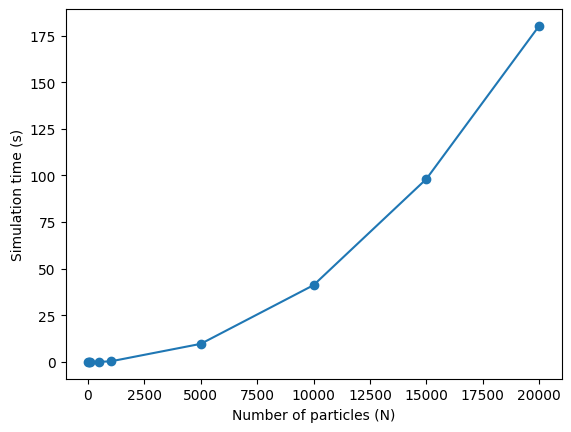

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(n_values, total_times, 'o-')
ax.set_xlabel('Number of particles (N)')
ax.set_ylabel('Simulation time (s)')
fig.savefig('simulation_times.png')

In [ ]:
memory_usage = [0.0, 0.0, 0.0, 4.39453125, 17.09375, 800, 2200, 5000, 9000]

In [ ]:
np.save("mem_usage.npy",np.array((n_values,memory_usage)))#Saves the data as numpy file

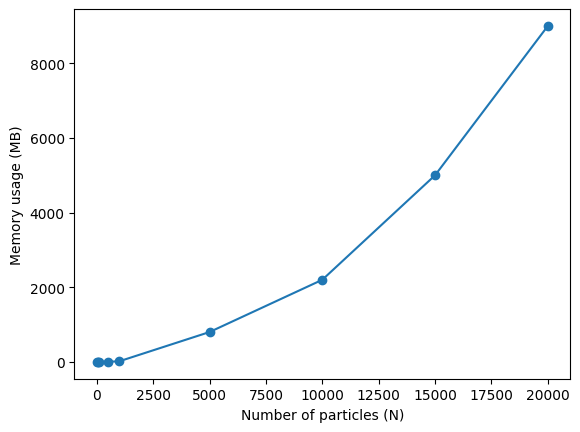

In [ ]:
fig, ax = plt.subplots()
ax.plot(n_values, memory_usage, 'o-')
ax.set_xlabel('Number of particles (N)')
ax.set_ylabel('Memory usage (MB)')
fig.savefig('memory_usage.png')


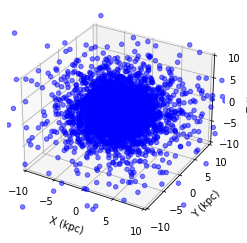

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot bulge particles
ax.scatter(X_bulge, Y_bulge, Z_bulge,marker ='.', c='r', alpha=0.5)

# Plot disk particles
ax.scatter(X_disk, Y_disk, Z_disk,marker ='.', c='g', alpha=0.5)

# Plot halo particles
ax.scatter(X_halo, Y_halo, Z_halo,marker ='.', c='b', alpha=0.5)

# Set axis labels
ax.set_xlabel('X (kpc)')
ax.set_ylabel('Y (kpc)')
ax.set_zlabel('Z (kpc)')

# Set axis limits
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)

# Save the figure
plt.savefig("initial_config.png")

# Show the figure
plt.show()
